In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

from scipy import signal

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

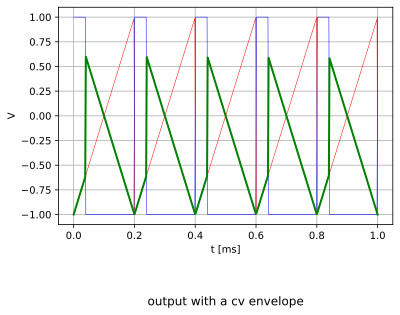

In [2]:

timePoints = np.linspace(0, 1, 500)
saw = signal.sawtooth(2 * np.pi * 5 * timePoints)
sig = np.sin(2 * np.pi * timePoints)
pwm = signal.square(2 * np.pi * 5 * timePoints, duty=0.2) #, duty=(sig + 1)/2)


#plot the results
figure, ax0 = plt.subplots()

#plot cv
ax0.plot(timePoints, saw, color="Red", linewidth=0.5)
ax0.plot(timePoints, pwm, color="Blue", linewidth=0.5)
ax0.plot(timePoints, saw * pwm, color="Green", linewidth=2)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.4)

plt.show()




# frequency doubler



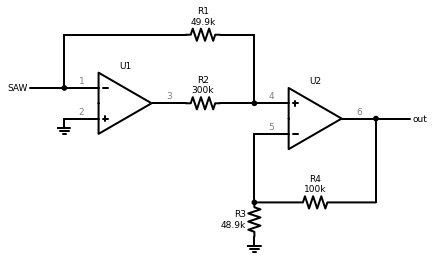

In [3]:
d = schemdraw.Drawing(unit=1.4, inches_per_unit=0.4, lw=2, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).label('U1'))

d += elm.Line().left().at(op1.in2).label('2', color='Grey')
d += elm.Ground()

d += elm.Line().left().at(op1.in1).label('1', color='Grey')
d += ( d1 := elm.Dot())
d += elm.Line().label("SAW", loc="left")

d += elm.Line().at(op1.out).right().label('3', color='Grey')
d += elm.Resistor().label("R2\n300k")
d += elm.Line().right()
d += elm.Dot()
d.push()

d += elm.Line().up().length(d.unit*2)
d += elm.Line().left()
d += elm.Resistor().label("R1\n49.9k")
d += elm.Line().left().tox(d1.end)
d += elm.Line().down().toy(d1.end)

d.pop()
d += elm.Line().right().label('4', color='Grey')
d += (op2 := elm.Opamp().flip().anchor('in2').label('U2'))

d += elm.Line().at(op2.out).right().label('6', color='Grey')
d += ( d2 := elm.Dot())
d += elm.Line().label("out", loc="right")

d += elm.Line().left().at(op2.in1).label('5', color='Grey')
d += elm.Line().down().length(d.unit*2)
d += elm.Dot()
d.push()
d += elm.Resistor().down().label("R3\n48.9k")
d += elm.Ground()

d.pop()
d += elm.Resistor().right().label("R4\n100k").tox(d2.end)
d += elm.Line().up().toy(d2.end)

d.draw()


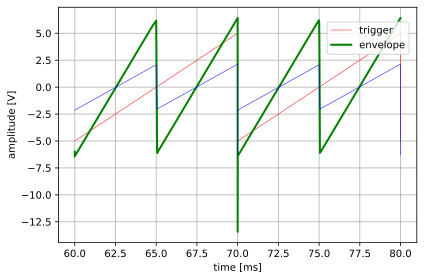

In [30]:
fd_circuit = Circuit('frequency_doubler')
fd_circuit.include(spice_library['TL072'])

fd_circuit.V('1', '+15V', fd_circuit.gnd, 'DC 15')
fd_circuit.V('2', '-15V', fd_circuit.gnd, 'DC -15')
fd_circuit.V('3', '1', fd_circuit.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')

#the opamps
#                        NON-INVERTING INPUT
#                        |             INVERTING INPUT
#                        |             |      POSITIVE POWER SUPPLY
#                        |             |      |       NEGATIVE POWER SUPPLY
#                        |             |      |       |       OUTPUT
#                        |             |      |       |       |
fd_circuit.X(1, 'TL072', fd_circuit.gnd,  '1',   '+15V', '-15V', '3')
fd_circuit.X(2, 'TL072', '4',          '5',   '+15V', '-15V', '6')
fd_circuit.R(1, '1', '4', 55@u_kΩ)
fd_circuit.R(2, '3', '4', 300@u_kΩ)
fd_circuit.R(3, '5', fd_circuit.gnd, 49.9@u_kΩ)
fd_circuit.R(4, '5', '6', 100@u_kΩ)

fd_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
fd_analysis = fd_simulator.transient(step_time=0.5@u_ms, start_time=60@u_ms, end_time=80@u_ms)

fd_figure, fd_ax = plt.subplots()

fd_ax.set_xlabel('time [ms]')
fd_ax.set_ylabel('amplitude [V]')
fd_ax.plot(u_ms(fd_analysis['1'].abscissa), fd_analysis['1'], color='Red', linewidth=0.5)
fd_ax.plot(u_ms(fd_analysis['6'].abscissa), fd_analysis['6'], color='Green', linewidth=2)
fd_ax.plot(u_ms(fd_analysis['4'].abscissa), fd_analysis['4'], color='Blue', linewidth=0.5)

fd_ax.legend(('trigger', 'envelope'), loc=(0.75,0.8))

plt.grid()
plt.tight_layout()
plt.show()


with a sine input

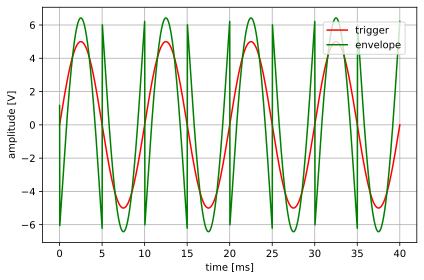

In [31]:
fd_circuit.V3.dc_value = 'DC 5V AC 5V SIN(0 5 100)'
fd_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
fd_analysis = fd_simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=40@u_ms)

fd_figure, fd_ax = plt.subplots()

fd_ax.set_xlabel('time [ms]')
fd_ax.set_ylabel('amplitude [V]')
fd_ax.plot(u_ms(fd_analysis['1'].abscissa), fd_analysis['1'], color='Red')
fd_ax.plot(u_ms(fd_analysis['6'].abscissa), fd_analysis['6'], color='Green')

fd_ax.legend(('trigger', 'envelope'), loc=(0.75,0.8))

plt.grid()
plt.tight_layout()
plt.show()


### *frequency shifter*

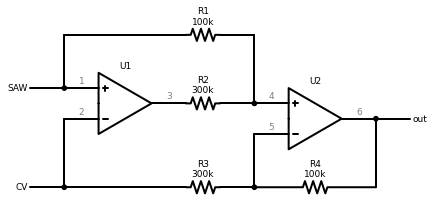

In [6]:
d = schemdraw.Drawing(unit=1.4, inches_per_unit=0.4, lw=2, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).flip().label('U1'))

d += elm.Line().left().at(op1.in2).label('1', color='Grey')
d += ( d1 := elm.Dot())
d += elm.Line().label("SAW", loc="left")

d += elm.Line().at(op1.out).right().label('3', color='Grey')
d += elm.Resistor().label("R2\n300k")
d += elm.Line().right()
d += elm.Dot()
d.push()

d += elm.Line().up().length(d.unit*2)
d += elm.Line().left()
d += elm.Resistor().label("R1\n100k")
d += elm.Line().left().tox(d1.end)
d += elm.Line().down().toy(d1.end)

d.pop()
d += elm.Line().right().label('4', color='Grey')
d += (op2 := elm.Opamp().flip().anchor('in2').label('U2'))

d += elm.Line().at(op2.out).right().label('6', color='Grey')
d += ( d2 := elm.Dot())
d += elm.Line().label("out", loc="right")

d += elm.Line().left().at(op1.in1).label('2', color='Grey')
d += elm.Line().down().length(d.unit*2)
d += ( d4 := elm.Dot() )

d += elm.Line().left().at(op2.in1).label('5', color='Grey')
d += elm.Line().down().toy(d4.end)
d += ( d3 := elm.Dot() )

d += elm.Line().down().at(d2.end).toy(d3.end)
d += elm.Resistor().left().tox(d3.end).label("R4\n100k")
d += elm.Line().left()
d += elm.Resistor().label("R3\n300k")
d += elm.Line().tox(d4.end)
d += elm.Line().label("CV", loc="left")
d.draw()


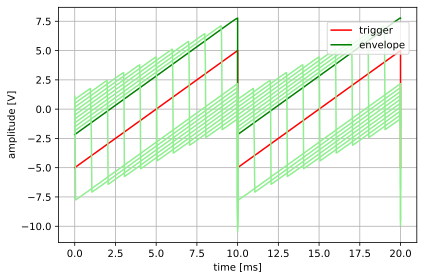

In [7]:
fd_circuit = Circuit('frequency_shifter')
fd_circuit.include(spice_library['TL072'])

fd_circuit.V('1', '+15V', fd_circuit.gnd, 'DC 15')
fd_circuit.V('2', '-15V', fd_circuit.gnd, 'DC -15')
fd_circuit.V('3', '1', fd_circuit.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
fd_circuit.V('4', '2', fd_circuit.gnd, '5V')

#the opamps
#                        NON-INVERTING INPUT
#                        |             INVERTING INPUT
#                        |             |      POSITIVE POWER SUPPLY
#                        |             |      |       NEGATIVE POWER SUPPLY
#                        |             |      |       |       OUTPUT
#                        |             |      |       |       |
fd_circuit.X(1, 'TL072', '2',          '1',   '+15V', '-15V', '3')
fd_circuit.X(2, 'TL072', '4',          '5',   '+15V', '-15V', '6')
fd_circuit.R(1, '1', '4', 100@u_kΩ)
fd_circuit.R(2, '3', '4', 300@u_kΩ)
fd_circuit.R(3, '5', '2', 300@u_kΩ)
fd_circuit.R(4, '5', '6', 100@u_kΩ)

fd_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
fd_analysis = fd_simulator.transient(step_time=0.5@u_ms, start_time=0@u_ms, end_time=20@u_ms)

fd_figure, fd_ax = plt.subplots()

fd_ax.set_xlabel('time [ms]')
fd_ax.set_ylabel('amplitude [V]')
fd_ax.plot(u_ms(fd_analysis['1'].abscissa), fd_analysis['1'], color='Red')
fd_ax.plot(u_ms(fd_analysis['6'].abscissa), fd_analysis['6'], color='Green')

for shift in np.arange(-5, 5, 1) :
    fd_circuit.V4.dc_value = f"{shift}V"
    shift_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
    shift_analysis = shift_simulator.transient(step_time=0.5@u_ms, start_time=0@u_ms, end_time=20@u_ms)
    fd_ax.plot(u_ms(shift_analysis['6'].abscissa), shift_analysis['6'], color='LightGreen')

fd_ax.legend(('trigger', 'envelope'), loc=(0.75,0.8))

plt.grid()
plt.tight_layout()
plt.show()


shifter with two sines

# electro notes animator


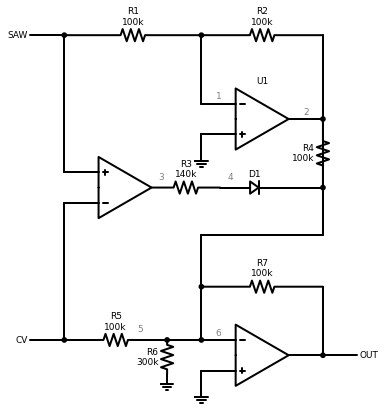

In [8]:
d = schemdraw.Drawing(unit=1.4, inches_per_unit=0.4, lw=2, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).label('U1'))

d += elm.Line().left().at(op1.in1).label('1', color='Grey')
d += elm.Line().up().length(d.unit*2)
d += ( d1 := elm.Dot())
d += elm.Resistor().left().length(d.unit*4).label("R1\n100k")
d += ( d2 := elm.Dot())                            
d.push()
d += elm.Line().label("SAW", loc="left")

d += elm.Line().right().at(op1.out).label('2', color='Grey')
d += ( d3 := elm.Dot() )
d += elm.Line().up().toy(d1.end)
d += elm.Resistor().left().tox(d1.end).label("R2\n100k")

d.pop()
d += elm.Line().down().length(d.unit*4)
d += elm.Line().right()
d += ( op2 := elm.Opamp().flip().anchor("in2"))

d += elm.Resistor().right().length(d.unit*2).at(op2.out).label("R3\n140k").label('3', color='Grey', loc="top", ofst=(-1, 0))
d += elm.Diode().length(d.unit*2).label("D1").label('4', color='Grey', loc="top", ofst=(-1, 0))
d += elm.Line().tox(d3.end)
d += ( d4 := elm.Dot() )
d += elm.Resistor().up().toy(d3.end).label("R4\n100k")

d += elm.Line().left().at(op2.in1).tox(d2.end)
d += elm.Line().down().length(d.unit*4)
d += elm.Dot()
d.push()
d += elm.Line().right()
d += elm.Resistor().label("R5\n100k").label('5', color='Grey', loc="top", ofst=(1, 0))
d += elm.Line()
d += elm.Dot()
d.push()

d += elm.Resistor().down().label("R6\n300k")
d += elm.Ground()

d.pop()
d += elm.Line()
d += ( d5 := elm.Dot() )
d += elm.Line().label('6', color='Grey')
d += ( op3 := elm.Opamp().anchor("in1") )

d.pop()
d += elm.Line().left().label("CV", loc="left")

d += elm.Line().right().at(op3.out)
d += elm.Dot()
d.push()

d += elm.Line().label("OUT", loc="right")

d.pop()
d += elm.Line().up().length(d.unit*2)
d += elm.Resistor().left().tox(d5.end).label("R7\n100k")
d += ( d6 := elm.Dot() )
d.push()
d += elm.Line().down().toy(d5.end)

d.pop()
d += elm.Line().up().length(d.unit*1.5)
d += elm.Line().right().tox(d3.end)
d += elm.Line().up().toy(d3.end)

d += elm.Line().left().at(op3.in2)
d += elm.Line().down().length(d.unit/2)
d += elm.Ground()

d += elm.Line().left().at(op1.in2)
d += elm.Line().down().length(d.unit/2)
d += elm.Ground()

d.draw()


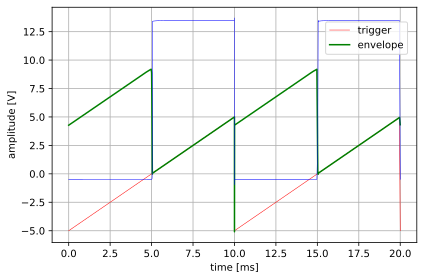

In [35]:
fd_circuit = Circuit('frequency_shifter')
fd_circuit.include(spice_library['TL072'])
fd_circuit.include(spice_library['D1N4148'])

fd_circuit.V('1', '+15V', fd_circuit.gnd, 'DC 15')
fd_circuit.V('2', '-15V', fd_circuit.gnd, 'DC -15')
fd_circuit.V('3', 'SAW', fd_circuit.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
fd_circuit.V('4', 'CV', fd_circuit.gnd, '0V')

#the opamps
#                        NON-INVERTING INPUT
#                        |             INVERTING INPUT
#                        |             |      POSITIVE POWER SUPPLY
#                        |             |      |       NEGATIVE POWER SUPPLY
#                        |             |      |       |       OUTPUT
#                        |             |      |       |       |
fd_circuit.X(1, 'TL072', fd_circuit.gnd,'1',   '+15V', '-15V', '2')
fd_circuit.X(2, 'TL072', 'SAW',         'CV',  '+15V', '-15V', '3')
fd_circuit.X(3, 'TL072', fd_circuit.gnd,'6',   '+15V', '-15V', 'OUT')
fd_circuit.R(1, 'SAW', '1', 100@u_kΩ)
fd_circuit.R(2, '1', '2', 100@u_kΩ)
fd_circuit.R(3, '3', '4', 140@u_kΩ)
fd_circuit.R(4, '6', '2', 100@u_kΩ)
fd_circuit.R(5, 'CV', '5', 100@u_kΩ)
fd_circuit.R(6, '5', '-15V', 300@u_kΩ)
fd_circuit.R(7, '6', 'OUT', 100@u_kΩ)
fd_circuit.D('1', '6', '4', model='D1N4148')


fd_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
fd_analysis = fd_simulator.transient(step_time=0.5@u_ms, start_time=0@u_ms, end_time=20@u_ms)

fd_figure, fd_ax = plt.subplots()

fd_ax.set_xlabel('time [ms]')
fd_ax.set_ylabel('amplitude [V]')
fd_ax.plot(u_ms(fd_analysis['SAW'].abscissa), fd_analysis['SAW'], color='Red', linewidth=0.5)
fd_ax.plot(u_ms(fd_analysis['OUT'].abscissa), fd_analysis['OUT'], color='Green')
fd_ax.plot(u_ms(fd_analysis['4'].abscissa), fd_analysis['4'], color='Blue', linewidth=0.5)

#for shift in np.arange(-5, 5, 1) :
#    fd_circuit.V4.dc_value = f"{shift}V"
#    shift_simulator = fd_circuit.simulator(temperature=25, nominal_temperature=25)
#    shift_analysis = shift_simulator.transient(step_time=0.5@u_ms, start_time=0@u_ms, end_time=20@u_ms)
#    fd_ax.plot(u_ms(shift_analysis['6'].abscissa), shift_analysis['6'], color='LightGreen')

fd_ax.legend(('trigger', 'envelope'), loc=(0.75,0.8))

plt.grid()
plt.tight_layout()
plt.show()
